# TODO: convert model saving and loading to save_json and load_json

In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# ML
from regression import SparseKRR, LR
from kernels import build_kernel
from errors import MAE, RMSE

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

In [2]:
# TODO: table generator

# Initial setup

In [3]:
# Load train and test sets
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [4]:
# Set structure labels for loading from the HDF5 file
n_digits = len(str(n_structures - 1))
datasets = [str(i).zfill(n_digits) for i in train_idxs]

In [5]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

# Functions

In [6]:
def transform_skrr_oos(cutoff, datasets, property_name,
                   soaps_file, ref_soaps_file,
                   rep_idxs_file, model_file,
                   skrr_file, work_dir='.'):
    
    # Read SOAPs
    soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=False)
    
    # Load reference SOAPs
    representative_soaps = load_structures_from_hdf5(ref_soaps_file, datasets=datasets, concatenate=True)
    representative_idxs = np.loadtxt(rep_idxs_file, usecols=0, dtype=int)
    representative_soaps = representative_soaps[representative_idxs, :]
    
    # Unpickle the kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
    
    model_dict.pop('sigma')
    model_dict.pop('regularization')
    #kernel_type = model_dict['kernel_type']
    #gamma = model_dict['gamma']
    
    # Unpickle the reference models
    with open(skrr_file, 'r') as f:
        skrr_dict = json.load(f)
                
    # Turn lists into arrays
    for k, v in skrr_dict.items():
        if isinstance(v, list):
            skrr_dict[k] = np.array(v)
                        
    # Build structure kernel
    KNM = build_kernel(soaps, representative_soaps, **model_dict)
                       #kernel=kernel_type, gamma=gamma)
        
    # Initialize SKRR model
    skrr = SparseKRR()
    skrr.__dict__ = skrr_dict
    
    # Predict based on the loaded SparseKRR object
    Yp_structures = skrr.transform(KNM)
    
    # Iteratively operate on environments to save memory
    Yp_environments = []
    for soap in tqdm(soaps):
        KNM_environments = build_kernel(soap, representative_soaps, **model_dict)
                                    #kernel=kernel_type, gamma=gamma)
        Yp_environments.append(skrr.transform(KNM_environments))
        
    Yp_environments = np.concatenate(Yp_environments)

    np.savetxt(f'{work_dir}/predicted_structure_{property_name}.dat', Yp_structures)
    np.savetxt(f'{work_dir}/predicted_environment_{property_name}.dat', Yp_environments)

# DEEM_10k

In [6]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
structure_properties = {}
for pn in property_names:
    structure_properties[pn] = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/structure_{pn}.dat')

In [7]:
for cutoff in cutoffs:
    
    # Set data directory
    model_dir = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR'
    data_dir = f'../Processed_Data/DEEM_10k/Data/{cutoff}'
    
    # Set working directory
    work_dir = f'{data_dir}/Kernel_Models/Gaussian/KRR'
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
    
    # Set SOAP files
    soaps_file = f'{data_dir}/soaps.hdf5'
    rep_idxs_file = f'{data_dir}/FPS_representatives.idxs'
            
    # Read SOAPs
    soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=False)
    
    # Build representative SOAPs
    representative_idxs = np.loadtxt(rep_idxs_file, usecols=0, dtype=int)
    representative_soaps = np.vstack([soaps[i] for i in train_idxs])
    representative_soaps = representative_soaps[representative_idxs, :]
    
    # Loop over structure properties
    for pn, Y in structure_properties.items():
        
        # Load model parameters
        model_file = f'{model_dir}/{pn}_mae_parameters.json'

        # Load kernel parameters
        with open(model_file, 'r') as f:
            model_dict = json.load(f)

        #kernel_type = model_dict['kernel_type']
        #gamma = model_dict['gamma']
        kernel_dict = model_dict.copy()
        kernel_dict.pop('sigma')
        kernel_dict.pop('regularization')

        # Build kernels
        KMM = build_kernel(representative_soaps, representative_soaps, **kernel_dict)
                           #kernel=kernel_type, gamma=gamma)
        KNM = build_kernel(soaps, representative_soaps, **kernel_dict)
                           #kernel=kernel_type, gamma=gamma)
    
        # Prepare properties and scaling
        Yc = Y - np.mean(Y[train_idxs])
        delta = np.var(Yc[train_idxs]) * KMM.shape[0] / np.trace(KMM)
        
        # Load regression parameters
        sigma = model_dict['sigma']
        regularization = model_dict['regularization']
    
        # Initialize sparse KRR
        skrr = SparseKRR(sigma=sigma, regularization=regularization, rcond=None)
        skrr.fit(delta*KNM[train_idxs, :], delta*KMM, delta*Yc[train_idxs])
        
        # Pickle the models
        # Copy the dict so we can make the numpy arrays lists
        skrr_dict = skrr.__dict__.copy()
        
        # Convert arrays to lists
        for k, v in skrr_dict.items():
            if isinstance(v, np.ndarray):
                skrr_dict[k] = v.tolist()
        
        # Save
        with open(f'{data_dir}/skrr_{pn}.json', 'w') as f:
            json.dump(skrr_dict, f)
        
        # Predict properties
        Yp_structures = np.zeros(len(soaps))
        Yp_structures[train_idxs] = skrr.transform(KNM[train_idxs, :])
        Yp_structures[test_idxs] = skrr.transform(KNM[test_idxs, :])
        
        # Iteratively predict environment properties to save memory
        Yp_environments = []
        for soap in tqdm(soaps):
            KNM_environments = build_kernel(soap, representative_soaps,
                                        kernel=kernel_type, gamma=gamma)
            Yp_environments.append(skrr.transform(KNM_environments))

        Yp_environments = np.concatenate(Yp_environments)
        
        # Save predicted properties
        np.savetxt(f'{work_dir}/predicted_structure_{pn}.dat', Yp_structures)
        np.savetxt(f'{work_dir}/predicted_environment_{pn}.dat', Yp_environments)

# IZA_226 on DEEM_10k

In [8]:
for cutoff in cutoffs:
    
    # Set the working directory
    work_dir = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/Kernel_Models/Gaussian/KRR'
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
      
    # Set the SOAP files
    soaps_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    ref_soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    rep_idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_representatives.idxs'

    # Compute SKRR predictions for each property
    for pn in structure_properties.keys():
        model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/{pn}_mae_parameters.json'
        skrr_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/skrr_{pn}.json'
        transform_skrr_oos(cutoff, datasets, pn,
                           soaps_file, ref_soaps_file,
                           rep_idxs_file, model_file,
                           skrr_file, work_dir=work_dir)

# COD_196 on DEEM_10k

In [9]:
for cutoff in cutoffs:
    
    # Set the working directory
    work_dir = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/Kernel_Models/Gaussian/KRR'
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
      
    # Set the SOAP files
    soaps_file = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    ref_soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    rep_idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_representatives.idxs'

    # Compute SKRR predictions for each property
    for pn in structure_properties.keys():
        model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/{pn}_mae_parameters.json'
        skrr_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/skrr_{pn}.json'
        transform_skrr_oos(cutoff, datasets, pn,
                           soaps_file, ref_soaps_file,
                           rep_idxs_file, model_file,
                           skrr_file, work_dir=work_dir)

# LR DEEM 330k properties

In [6]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [7]:
# Load indices of 10k structures relative to the 330k dataset
idxs_deem_10k = np.loadtxt('../Processed_Data/DEEM_330konDEEM_10k/deem_10k.idxs', dtype=int)
deem_10k_ids = idxs_deem_10k + 8000001

In [8]:
# Load properties
volumes_330k = np.loadtxt('../Processed_Data/DEEM_330k/structure_volumes.dat')
energies_330k = np.loadtxt('../Processed_Data/DEEM_330k/structure_energies.dat')
n_Si_330k = np.loadtxt('../Processed_Data/DEEM_330k/n_Si.dat', dtype=int)

In [9]:
# Load SOAPs
f = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
dataset = f['0']

In [10]:
soaps_train = dataset[idxs_deem_10k][train_idxs]
volumes_train = volumes_330k[idxs_deem_10k][train_idxs]
energies_train = energies_330k[idxs_deem_10k][train_idxs]

In [11]:
# TODO: Should probably do this with normalized SOAPs for consistency
# Center and scale SOAPs
soaps_center = np.mean(soaps_train, axis=0)
soaps_scale = np.linalg.norm(soaps_train - soaps_center)

# Center and scale properties
volumes_center = np.mean(volumes_train)
volumes_scale = np.linalg.norm(volumes_train - volumes_center)

energies_center = np.mean(energies_train)
energies_scale = np.linalg.norm(energies_train - energies_center)

In [12]:
print(np.trace(np.matmul(np.transpose((soaps_train - soaps_center) / soaps_scale),
                         (soaps_train - soaps_center) / soaps_scale)))

1.0000000000000044


In [13]:
batchsize = 100000
n_batches = len(n_Si_330k) // batchsize
if len(n_Si_330k) % batchsize > 0:
    n_batches += 1

## Volumes

In [14]:
# Train linear regression model on volumes
regularization = 1.0E-12
lr_volume = LR(regularization=1.0E-12)
lr_volume.fit((soaps_train - soaps_center) / soaps_scale, 
              (volumes_train - volumes_center) / volumes_scale)

In [15]:
predicted_volumes_330k = np.zeros(len(n_Si_330k))

for n in tqdm(range(0, n_batches)):
    predicted_volumes_330k[n*batchsize:(n+1)*batchsize] = \
        lr_volume.predict((dataset[n*batchsize:(n+1)*batchsize] - soaps_center) / soaps_scale)

In [16]:
MAE(predicted_volumes_330k * volumes_scale + volumes_center, volumes_330k)

1.2919612971735237

In [38]:
err_vol = volumes_330k - (predicted_volumes_330k * volumes_scale + volumes_center)
abs_err_vol = np.abs(err_vol)
idxs_volume = np.argsort(abs_err_vol)[::-1]
print(idxs_volume + 8000001)
print(volumes_330k[idxs_volume])
print(predicted_volumes_330k[idxs_volume] * volumes_scale + volumes_center)

[8265046 8321582 8171811 ... 8286483 8326381 8226999]
[56.7        29.45978239 29.89086515 ... 45.10845265 47.55900402
 45.34135383]
[-1844.32352401   197.02730202   151.92565143 ...    45.10846684
    47.55899277    45.34135582]


In [18]:
problem_ids = np.nonzero((predicted_volumes_330k * volumes_scale + volumes_center) < 0)[0] + 8000001
print(problem_ids)
print(np.intersect1d(problem_ids, deem_10k_ids))

[8072749 8094886 8129504 8265046 8307987]
[]


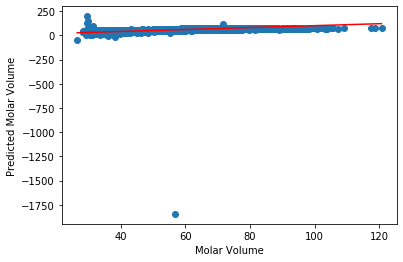

In [50]:
plt.scatter(volumes_330k, predicted_volumes_330k * volumes_scale + volumes_center)
plt.plot([volumes_330k.min(), volumes_330k.max()], [volumes_330k.min(), volumes_330k.max()], c='r')
plt.xlabel('Molar Volume')
plt.ylabel('Predicted Molar Volume')
plt.show()

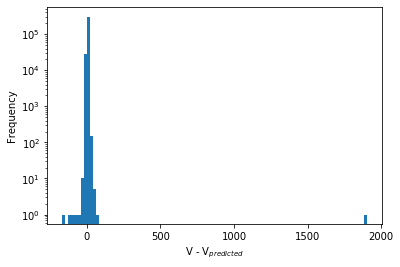

In [47]:
plt.hist(err_vol, bins=100, density=False, log=True)
plt.xlabel(r'V$_{true}$ - V$_{predicted}$')
plt.ylabel('Frequency')
plt.show()

## Energies

In [20]:
# Train linear regression model on energies
regularization = 1.0E-12
lr_energy = LR(regularization=1.0E-12)
lr_energy.fit((soaps_train - soaps_center) / soaps_scale, 
              (energies_train - energies_center) / energies_scale)

In [21]:
predicted_energies_330k = np.zeros(len(n_Si_330k))

for n in tqdm(range(0, n_batches)):
    predicted_energies_330k[n*batchsize:(n+1)*batchsize] = \
        lr_energy.predict((dataset[n*batchsize:(n+1)*batchsize] - soaps_center) / soaps_scale)

In [22]:
MAE(predicted_energies_330k * energies_scale + energies_center, energies_330k)

0.11878494716102829

In [40]:
err_energy = energies_330k - (predicted_energies_330k * energies_scale + energies_center)
abs_err_energy = np.abs(err_energy)
idxs_energy = np.argsort(abs_err_energy)[::-1]
print(idxs_energy + 8000001)
print(energies_330k[idxs_energy])
print(predicted_energies_330k[idxs_energy] * energies_scale + energies_center)

[8265046 8329346 8326006 ... 8312537 8070075 8101902]
[-12415.082194 -12408.85135  -12388.589212 ... -12390.823146 -12391.253359
 -12398.135898]
[-12035.26078202 -12182.60651453 -12234.15281071 ... -12390.82314551
 -12391.25335866 -12398.13589817]


In [32]:
problem_ids = np.nonzero(abs_err_energy > (np.mean(abs_err_energy) + 3*np.std(abs_err_energy)))[0] + 8000001
print(problem_ids)
print(np.intersect1d(problem_ids, deem_10k_ids))

[8000265 8006012 8008151 8008527 8008649 8009060 8012138 8014463 8014733
 8015502 8016843 8017871 8018930 8019477 8022741 8025529 8026092 8027973
 8028240 8028409 8030714 8033884 8034062 8034933 8035078 8035895 8037584
 8038665 8040073 8041200 8041922 8044006 8047205 8047405 8047780 8049127
 8049539 8050134 8050869 8051583 8054009 8055753 8055910 8056847 8076340
 8076717 8078318 8078618 8079313 8086856 8093507 8093816 8094142 8095801
 8101419 8103559 8104704 8109166 8109672 8113521 8116867 8117134 8117664
 8119068 8120271 8120379 8120588 8120677 8122133 8122860 8126142 8126242
 8126910 8127994 8129274 8129288 8129301 8129961 8130393 8130896 8131602
 8132948 8137257 8143095 8143246 8144653 8144708 8145253 8146174 8147032
 8147078 8147455 8149238 8150003 8150186 8152629 8152984 8154471 8154939
 8155178 8155817 8156521 8157489 8161330 8164674 8165811 8167860 8168523
 8169332 8171811 8174640 8181526 8182321 8185699 8186882 8187197 8187831
 8190546 8201663 8214912 8214966 8216928 8216972 82

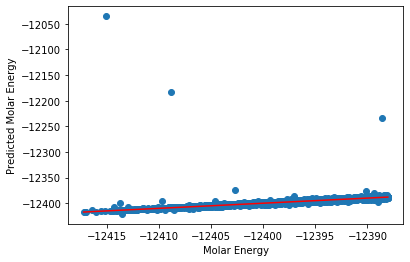

In [48]:
plt.scatter(energies_330k, predicted_energies_330k * energies_scale + energies_center)
plt.plot([energies_330k.min(), energies_330k.max()], [energies_330k.min(), energies_330k.max()], c='r')
plt.xlabel('Molar Energy')
plt.ylabel('Predicted Molar Energy')
plt.show()

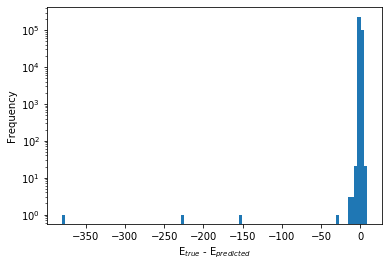

In [49]:
plt.hist(err_energy, bins=100, density=False, log=True)
plt.xlabel(r'E$_{true}$ - E$_{predicted}$')
plt.ylabel('Frequency')
plt.show()

## Cleanup

In [26]:
f.close()

# TESTING

In [10]:
Y_mean = {}
for pn in ['volumes', 'energies']:
    Y_mean[pn] = np.loadtxt(f'../Processed_Data/DEEM_10k/structure_{pn}.dat')
    Y_mean[pn] = np.mean(Y_mean[pn][train_idxs])

## DEEM_10k

In [11]:
for cutoff in cutoffs:
    for pn in ['volumes', 'energies']:
        Y = np.loadtxt(f'../Processed_Data/DEEM_10k/structure_{pn}.dat')
        Yp = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/Kernel_Models/Gaussian/KRR/predicted_structure_{pn}.dat')
        Yp += Y_mean[pn]
        mae = MAE(Y[test_idxs], Yp[test_idxs])
        rmse = RMSE(Y[test_idxs], Yp[test_idxs])
        
        print(f'{cutoff} {pn} MAE: {mae}')
        print(f'{cutoff} {pn} RMSE: {rmse}')

3.5 volumes MAE: 2.5997947727897315
3.5 volumes RMSE: 3.7752991352703043
3.5 energies MAE: 0.6679147247205498
3.5 energies RMSE: 0.9387783017460885
6.0 volumes MAE: 1.0495045073138882
6.0 volumes RMSE: 1.8395137747385406
6.0 energies MAE: 0.4620307674679215
6.0 energies RMSE: 0.6693558441871916


## IZA_226 on DEEM_10k

In [12]:
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
canton_labels = np.unique(cantons)
print(canton_labels)

[1 2 3 4]


In [13]:
for cutoff in cutoffs:
    for pn in ['volumes', 'energies']:
        Y = np.loadtxt(f'../Processed_Data/IZA_226/structure_{pn}.dat')
        Yp = np.loadtxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/Kernel_Models/Gaussian/KRR/predicted_structure_{pn}.dat')
        Yp += Y_mean[pn]
        mae = MAE(Y, Yp)
        rmse = RMSE(Y, Yp)
        
        mae_cantons = []
        rmse_cantons = []
        for canton in canton_labels:
            canton_idxs = np.nonzero(cantons == canton)[0]
            mae_cantons.append(MAE(Y[canton_idxs], Yp[canton_idxs]))
            rmse_cantons.append(RMSE(Y[canton_idxs], Yp[canton_idxs]))
        
        print(f'{cutoff} {pn} MAE: {mae} | {mae_cantons}')
        print(f'{cutoff} {pn} RMSE: {rmse} | {rmse_cantons}')

3.5 volumes MAE: 5.597071553718962 | [5.020883636526268, 5.133356486889813, 5.723347282333311, 73.75013726284374]
3.5 volumes RMSE: 8.605924587042685 | [6.134566648951043, 6.918039863286284, 7.805476815109476, 73.75013726284374]
3.5 energies MAE: 1.2295647615576781 | [1.373044032164554, 1.0360946547118863, 1.2324221456353692, 19.61684120822065]
3.5 energies RMSE: 2.171330635572147 | [1.9481079899780755, 1.5760536561678975, 1.897466617273481, 19.61684120822065]
6.0 volumes MAE: 2.1119540047946535 | [1.0388339319867168, 1.880866454355247, 2.306643039039767, 54.62498337801229]
6.0 volumes RMSE: 4.900791784046571 | [1.2504230461314574, 3.339528549606324, 3.889657173836812, 54.62498337801229]
6.0 energies MAE: 0.612571796556233 | [0.7003589840531017, 0.5632240906939902, 0.5117597908439594, 10.415656737794052]
6.0 energies RMSE: 1.057806574792901 | [1.1468966982608606, 0.7223079787003455, 0.7144406626110872, 10.415656737794052]


## COD_196 on DEEM_10k

In [14]:
for cutoff in cutoffs:
    for pn in ['volumes', 'energies']:
        Y = np.loadtxt(f'../Processed_Data/COD_196/structure_{pn}.dat')
        Yp = np.loadtxt(f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/Kernel_Models/Gaussian/KRR/predicted_structure_{pn}.dat')
        Yp += Y_mean[pn]
        mae = MAE(Y, Yp)
        rmse = RMSE(Y, Yp)
        
        print(f'{cutoff} {pn} MAE: {mae}')
        print(f'{cutoff} {pn} RMSE: {rmse}')

3.5 volumes MAE: 8.806058367711302
3.5 volumes RMSE: 14.843398697350736
3.5 energies MAE: 36.22190421008153
3.5 energies RMSE: 108.65834586518969
6.0 volumes MAE: 3.223133406232656
6.0 volumes RMSE: 10.968619050371599
6.0 energies MAE: 29.63415327950305
6.0 energies RMSE: 95.48433053527935
